In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Focus/Code'
%ls

/content/drive/MyDrive/Focus/Code
 data_preprocessing.ipynb   EfficientNet_B3_A.ipynb   NASNetMobile_B.ipynb
'DenseNet(169)_A.ipynb'     EfficientNet_B3_B.ipynb
'DenseNet(169)_B.ipynb'     NASNetMobile_A.ipynb


In [3]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.applications import DenseNet169
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Input
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
batch_size = 16
dataset_code = 'B'
model_name = 'DenseNet169'
data_saved_dir = r'/content/drive/MyDrive/Focus/Dataset'
model_saved_dir = r'/content/drive/MyDrive/Focus/Models'
train_data_path = f'{data_saved_dir}/B_training.pkl'
val_data_path = f'{data_saved_dir}/B_validation.pkl'
test_data_path = f'{data_saved_dir}/B_testing.pkl'

In [8]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

train_images, train_labels = load_pickle(train_data_path)
val_images, val_labels = load_pickle(val_data_path)
test_images, test_labels = load_pickle(test_data_path)

print(f'Training images: {train_images.shape}')
print(f'Validation images: {val_images.shape}')
print(f'Testing images: {test_images.shape}')

Training images: (4383, 256, 256, 3)
Validation images: (936, 256, 256, 3)
Testing images: (946, 256, 256, 3)


In [9]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]
        return batch_images, batch_labels

train_data_generator = CustomDataGenerator(train_images, train_labels, batch_size)
val_data_generator = CustomDataGenerator(val_images, val_labels, batch_size)
test_data_generator = CustomDataGenerator(test_images, test_labels, batch_size)

In [10]:
efficient_net = DenseNet169(
    weights='imagenet',
    input_shape=(256,256,3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(Input(shape=(256, 256, 3)))
model.add(efficient_net)
model.add(Dense(units = 120, activation='relu'))
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)             │ (None, 1664)                │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │         199,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          14,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,857,321 (49.05 MB)

 Trainable params: 12,698,921 (48.44 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

model_dir = f'{model_saved_dir}/{dataset_code}_{model_name}'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
else:
    print(f'{model_dir} already exists')

filename = 'weights-improvement-{epoch:02d}-{val_accuracy:.2f}'
# Change the file extension to .keras
filepath = f'{model_dir}/{dataset_code}_{model_name}-{filename}.keras'

# Define the ModelCheckpoint with the corrected filepath
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Add callbacks to the list
callbacks_list = [checkpoint, early_stop]

In [12]:
history = model.fit(train_data_generator, epochs=50, validation_data=val_data_generator, callbacks = callbacks_list)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8426 - loss: 0.4623
Epoch 1: val_accuracy improved from -inf to 0.79487, saving model to /content/drive/MyDrive/Focus/Models/B_DenseNet169/B_DenseNet169-weights-improvement-01-0.79.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.8427 - loss: 0.4619 - val_accuracy: 0.7949 - val_loss: 56.7933
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8881 - loss: 0.2737
Epoch 2: val_accuracy improved from 0.79487 to 0.81517, saving model to /content/drive/MyDrive/Focus/Models/B_DenseNet169/B_DenseNet169-weights-improvement-02-0.82.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 89s 253ms/step - accuracy: 0.8881 - loss: 0.2737 - val_accuracy: 0.8152 - val_loss: 5.8827
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8934 - loss: 0.3110
Epoch 3: val_accuracy did not improve from 0.81517
274/274 ━━━━━━━━━━━━━━━━━━━━ 66s 240ms/step - accuracy: 0.8934 - loss: 0.3110 - val_accuracy: 0.7938 - val_loss: 0.4424
Epo

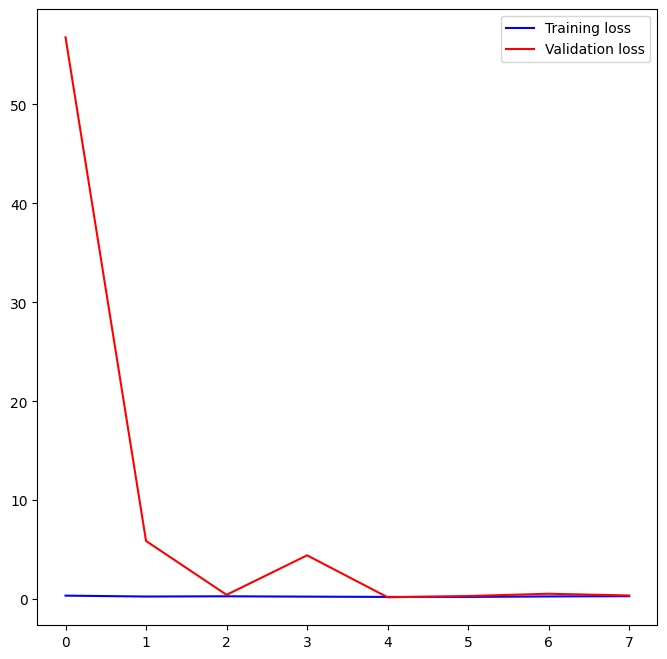

<Figure size 640x480 with 0 Axes>

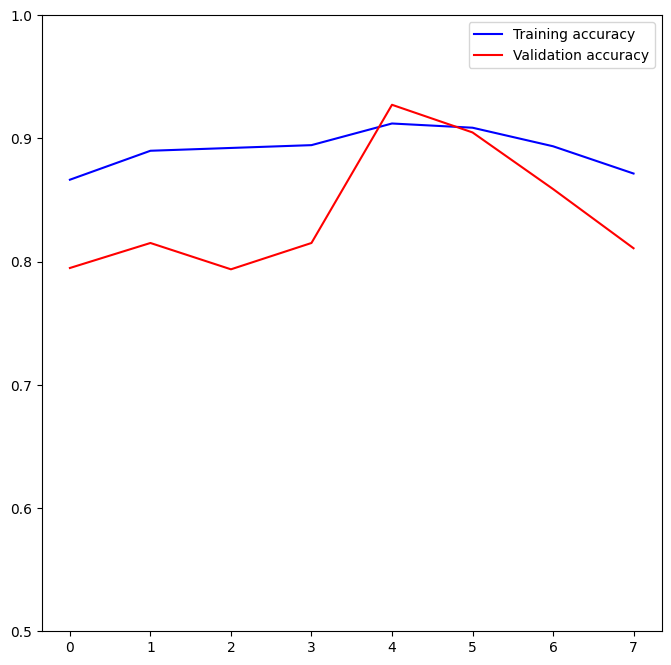

In [13]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.5, 1)
plt.show()

#### Testing on model till Last Epoch

60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 304ms/step


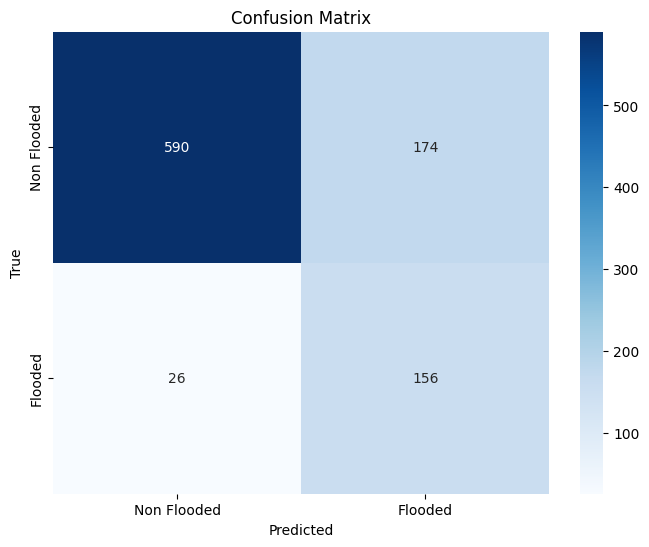

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.86       764
           1       0.47      0.86      0.61       182

    accuracy                           0.79       946
   macro avg       0.72      0.81      0.73       946
weighted avg       0.86      0.79      0.81       946



In [14]:
predictions = model.predict(test_data_generator)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))